In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

plt.style.use('dark_background')

In [2]:
D = np.load('D_matrix.npy', mmap_mode='r')
D.shape

(27445, 18)

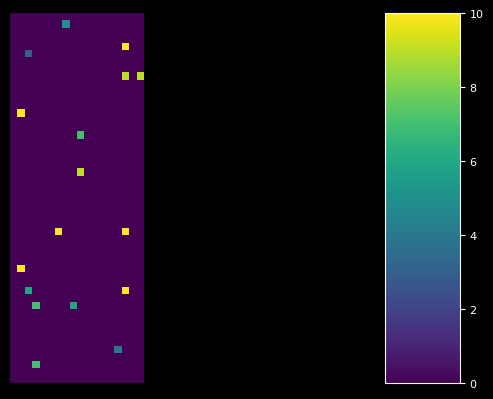

In [3]:
from matplotlib import gridspec

_, ax = plt.subplots(1, 2)

im = ax[0].imshow(D[:50, :])
ax[0].axis('off')

gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1])
ax[1] = plt.subplot(gs[1])
cbar = plt.colorbar(im, cax=ax[1])
cbar.ax.tick_params(labelsize=8)

plt.show()

In [5]:
num_users = int(0.1 * D.shape[0])

W = np.zeros((num_users, num_users), dtype=np.uint8) 
*W.shape, \
    W[0, :], W[1, :]

(2744,
 2744,
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8),
 array([0, 0, 0, ..., 0, 0, 0], dtype=uint8))

In [6]:
from numba import njit, prange

@njit(parallel=True)
def compute_similarity(W, l, thres):
    num_users = W.shape[0]
    
    for i in prange(num_users):
        for j in prange(i + 1, num_users):
            
            dot_product = np.sum(D[i, :] * D[j, :])
            norm_product = np.sqrt(np.sum(D[i, :] ** 2)) * np.sqrt(np.sum(D[j, :] ** 2))
            cosine_sim = dot_product / (norm_product + l)
            
            if cosine_sim >= thres:
                W[i, j] = W[j, i] = 1

In [7]:
l = 10 ** -5
thres = 0.2

compute_similarity(W, l, thres)

In [8]:
np.count_nonzero(W) / W.size * 100

0.5186242551997892

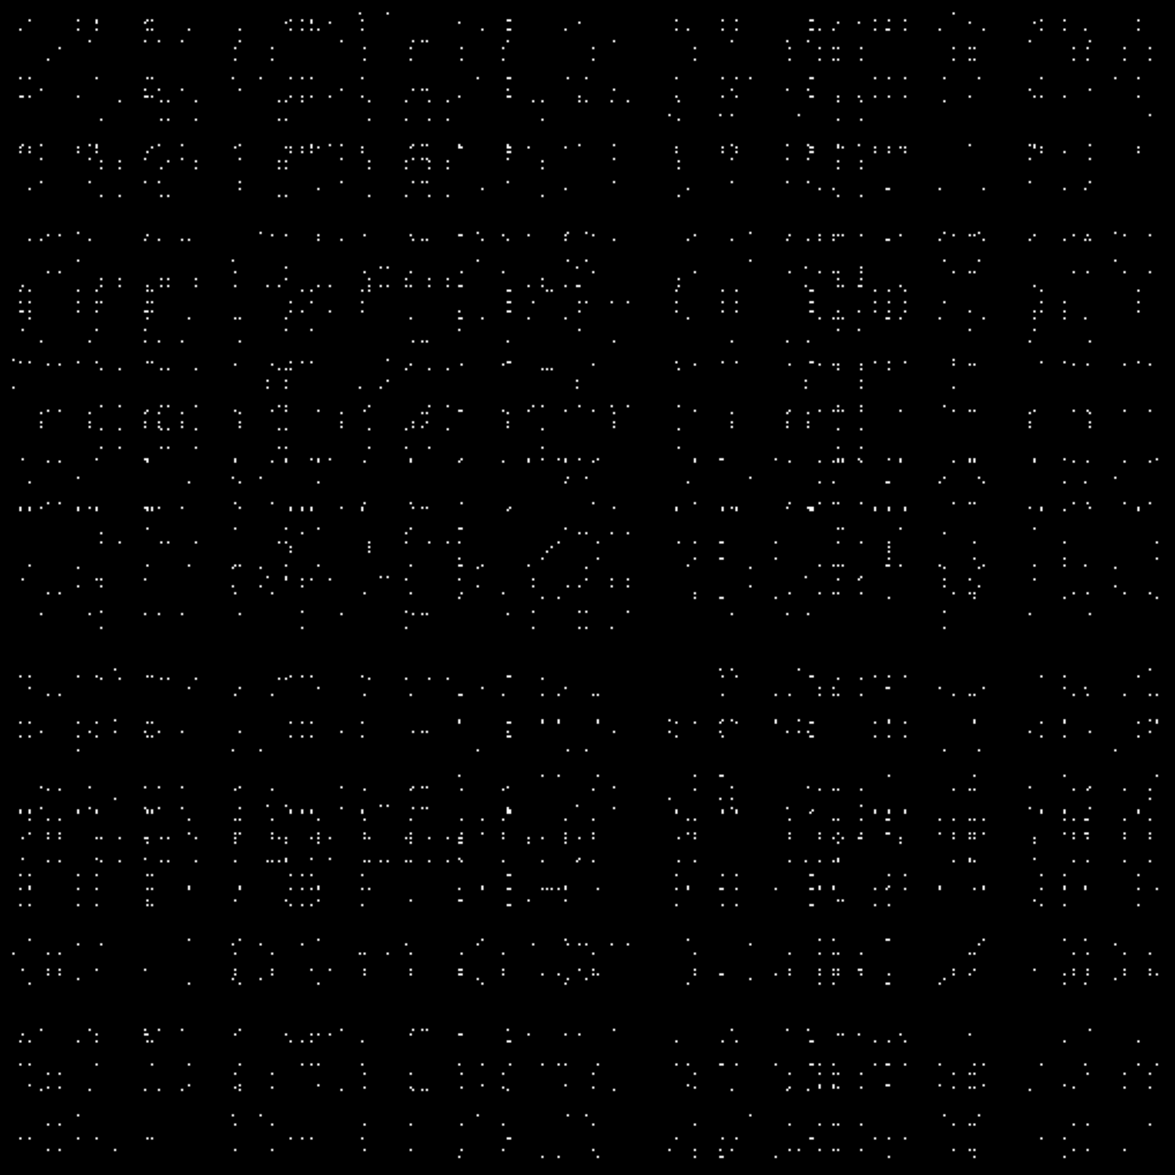

In [8]:
from matplotlib import gridspec

_, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.imshow(W[:500, :500], cmap='gray')
ax.axis('off')

plt.savefig('user_sim')
plt.show()

In [8]:
f'is symetric: {np.allclose(W, W.T)}'

'is symetric: True'

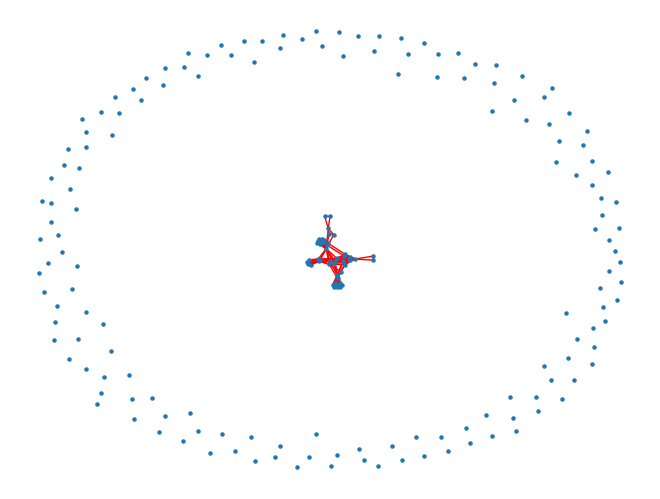

In [9]:
import networkx as nx

G = nx.from_numpy_matrix(W[:200, :200])

pos = nx.spring_layout(G)
nx.draw(
    G, 
    pos, 
    node_size=5,
    edge_color='red',
)

plt.savefig('graph')
plt.show()

In [10]:
column_with_most_nonzero = np.argmax(np.count_nonzero(D, axis=0))
np.count_nonzero(D[:, column_with_most_nonzero])

408

In [11]:
import torch

adj_matrix_t = torch.FloatTensor(W)
labels_t = torch.LongTensor(D.copy()[:W.shape[0], column_with_most_nonzero])

In [12]:
adj_matrix_t.shape, labels_t.shape

(torch.Size([2744, 2744]), torch.Size([2744]))

In [13]:
column_with_most_nonzero

9

In [14]:
from label_propagation import *

label_spreading = LabelSpreading(adj_matrix_t)
labels_t = torch.LongTensor(D.copy()[:W.shape[0], 16])
label_spreading.fit(labels_t, alpha=0.8)
label_spreading_output_labels = label_spreading.predict_classes()

labels:torch.Size([2744])
one hot: torch.Size([2744, 10])


RuntimeError: index 10 is out of bounds for dimension 1 with size 10

In [75]:
np.count_nonzero(label_spreading_output_labels)

0

In [15]:
n_cliques = 4
size_cliques = 10
caveman_graph = nx.connected_caveman_graph(n_cliques, size_cliques)
adj_matrix = nx.adjacency_matrix(caveman_graph).toarray()

# Create labels
labels = np.full(n_cliques * size_cliques, -1.)

# Only one node per clique is labeled. Each clique belongs to a different class.
labels[0] = 0
labels[size_cliques] = 1
labels[size_cliques * 2] = 2
labels[size_cliques * 3] = 3

# Create input tensors
adj_matrix_t = torch.FloatTensor(adj_matrix)
labels_t = torch.LongTensor(labels)

# Learn with Label Propagation
label_propagation = LabelPropagation(adj_matrix_t)
label_propagation.fit(labels_t)
label_propagation_output_labels = label_propagation.predict_classes()

# Learn with Label Spreading
label_spreading = LabelSpreading(adj_matrix_t)
label_spreading.fit(labels_t, alpha=0.8)
label_spreading_output_labels = label_spreading.predict_classes()

# Plot graphs
color_map = {-1: "orange", 0: "blue", 1: "green", 2: "red", 3: "cyan"}
input_labels_colors = [color_map[l] for l in labels]
lprop_labels_colors = [color_map[l] for l in label_propagation_output_labels.numpy()]
lspread_labels_colors = [color_map[l] for l in label_spreading_output_labels.numpy()]

plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 4, 1)
ax2 = plt.subplot(1, 4, 2)
ax3 = plt.subplot(1, 4, 3)

ax1.title.set_text("Raw data (4 classes)")
ax2.title.set_text("Label Propagation")
ax3.title.set_text("Label Spreading")

pos = nx.spring_layout(caveman_graph)
nx.draw(caveman_graph, ax=ax1, pos=pos, node_color=input_labels_colors, node_size=50)
nx.draw(caveman_graph, ax=ax2, pos=pos, node_color=lprop_labels_colors, node_size=50)
nx.draw(caveman_graph, ax=ax3, pos=pos, node_color=lspread_labels_colors, node_size=50)

# Legend
ax4 = plt.subplot(1, 4, 4)
ax4.axis("off")
legend_colors = ["orange", "blue", "green", "red", "cyan"]
legend_labels = ["unlabeled", "class 0", "class 1", "class 2", "class 3"]
dummy_legend = [ax4.plot([], [], ls='-', c=c)[0] for c in legend_colors]
plt.legend(dummy_legend, legend_labels)

plt.show()

/tmp/ipykernel_478077/1461190979.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(caveman_graph).toarray()


labels:torch.Size([40])
one hot: torch.Size([40, 10])


RuntimeError: index -1 is out of bounds for dimension 1 with size 10

In [6]:
from abc import abstractmethod
import torch

class BaseLabelPropagation:
    """Base class for label propagation models.

    Parameters
    ----------
    adj_matrix: torch.FloatTensor
        Adjacency matrix of the graph.
    """
    def __init__(self, adj_matrix):
        self.norm_adj_matrix = self._normalize(adj_matrix)
        self.n_nodes = adj_matrix.size(0)
        self.one_hot_labels = None 
        self.n_classes = None
        self.labeled_mask = None
        self.predictions = None

    @staticmethod
    @abstractmethod
    def _normalize(adj_matrix):
        raise NotImplementedError("_normalize must be implemented")

    @abstractmethod
    def _propagate(self):
        raise NotImplementedError("_propagate must be implemented")

    def _one_hot_encode(self, labels):
        # Get the number of classes
        classes = torch.unique(labels)
        classes = classes[classes != -1]
        self.n_classes = classes.size(0)

        # One-hot encode labeled data instances and zero rows corresponding to unlabeled instances
        unlabeled_mask = (labels == -1)
        labels = labels.clone()  # defensive copying
        labels[unlabeled_mask] = 0
        self.one_hot_labels = torch.zeros((self.n_nodes, self.n_classes), dtype=torch.float)
        print(f'one hot labels: {self.one_hot_labels.shape}')
        print(f'labels: {labels.shape}')
        self.one_hot_labels = self.one_hot_labels.scatter(1, labels.unsqueeze(1), 1)
        self.one_hot_labels[unlabeled_mask, 0] = 0

        self.labeled_mask = ~unlabeled_mask

    def fit(self, labels, max_iter, tol):
        """Fits a semi-supervised learning label propagation model.

        labels: torch.LongTensor
            Tensor of size n_nodes indicating the class number of each node.
            Unlabeled nodes are denoted with -1.
        max_iter: int
            Maximum number of iterations allowed.
        tol: float
            Convergence tolerance: threshold to consider the system at steady state.
        """
        self._one_hot_encode(labels)

        self.predictions = self.one_hot_labels.clone()
        prev_predictions = torch.zeros((self.n_nodes, self.n_classes), dtype=torch.float)

        for i in range(max_iter):
            # Stop iterations if the system is considered at a steady state
            variation = torch.abs(self.predictions - prev_predictions).sum().item()

            if variation < tol:
                print(f"The method stopped after {i} iterations, variation={variation:.4f}.")
                break

            prev_predictions = self.predictions
            self._propagate()

    def predict(self):
        return self.predictions

    def predict_classes(self):
        return self.predictions.max(dim=1).indices

In [7]:
class LabelSpreading(BaseLabelPropagation):
    def __init__(self, adj_matrix):
        super().__init__(adj_matrix)
        self.alpha = None

    @staticmethod
    def _normalize(adj_matrix):
        """Computes D^-1/2 * W * D^-1/2"""
        degs = adj_matrix.sum(dim=1)
        norm = torch.pow(degs, -0.5)
        norm[torch.isinf(norm)] = 1
        return adj_matrix * norm[:, None] * norm[None, :]

    def _propagate(self):
        self.predictions = (
            self.alpha * torch.matmul(self.norm_adj_matrix, self.predictions)
            + (1 - self.alpha) * self.one_hot_labels
        )

    def fit(self, labels, max_iter=1000, tol=1e-3, alpha=0.5):
        """
        Parameters
        ----------
        alpha: float
            Clamping factor.
        """
        self.alpha = alpha
        super().fit(labels, max_iter, tol)

In [8]:
class LabelPropagation(BaseLabelPropagation):
    def __init__(self, adj_matrix):
        super().__init__(adj_matrix)

    @staticmethod
    def _normalize(adj_matrix):
        """Computes D^-1 * W"""
        degs = adj_matrix.sum(dim=1)
        degs[degs == 0] = 1  # avoid division by 0 error
        return adj_matrix / degs[:, None]

    def _propagate(self):
        self.predictions = torch.matmul(self.norm_adj_matrix, self.predictions)

        # Put back already known labels
        self.predictions[self.labeled_mask] = self.one_hot_labels[self.labeled_mask]

    def fit(self, labels, max_iter=1000, tol=1e-3):
        super().fit(labels, max_iter, tol)

/tmp/ipykernel_546028/2363767904.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(caveman_graph).toarray()


one hot labels: torch.Size([40, 4])
labels: torch.Size([40])
The method stopped after 73 iterations, variation=0.0010.
one hot labels: torch.Size([40, 4])
labels: torch.Size([40])
The method stopped after 20 iterations, variation=0.0009.


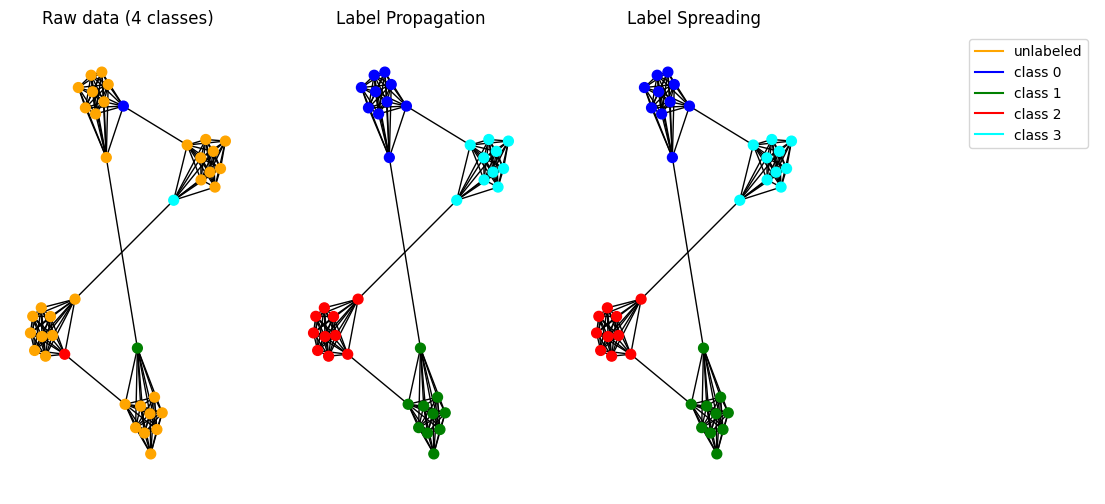

In [9]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Create caveman graph
n_cliques = 4
size_cliques = 10
caveman_graph = nx.connected_caveman_graph(n_cliques, size_cliques)
adj_matrix = nx.adjacency_matrix(caveman_graph).toarray()

# Create labels
labels = np.full(n_cliques * size_cliques, -1.)

# Only one node per clique is labeled. Each clique belongs to a different class.
labels[0] = 0
labels[size_cliques] = 1
labels[size_cliques * 2] = 2
labels[size_cliques * 3] = 3

# Create input tensors
adj_matrix_t = torch.FloatTensor(adj_matrix)
labels_t = torch.LongTensor(labels)

# Learn with Label Propagation
label_propagation = LabelPropagation(adj_matrix_t)
label_propagation.fit(labels_t)
label_propagation_output_labels = label_propagation.predict_classes()

# Learn with Label Spreading
label_spreading = LabelSpreading(adj_matrix_t)
label_spreading.fit(labels_t, alpha=0.8)
label_spreading_output_labels = label_spreading.predict_classes()

# Plot graphs
color_map = {-1: "orange", 0: "blue", 1: "green", 2: "red", 3: "cyan"}
input_labels_colors = [color_map[l] for l in labels]
lprop_labels_colors = [color_map[l] for l in label_propagation_output_labels.numpy()]
lspread_labels_colors = [color_map[l] for l in label_spreading_output_labels.numpy()]

plt.figure(figsize=(14, 6))
ax1 = plt.subplot(1, 4, 1)
ax2 = plt.subplot(1, 4, 2)
ax3 = plt.subplot(1, 4, 3)

ax1.title.set_text("Raw data (4 classes)")
ax2.title.set_text("Label Propagation")
ax3.title.set_text("Label Spreading")

pos = nx.spring_layout(caveman_graph)
nx.draw(caveman_graph, ax=ax1, pos=pos, node_color=input_labels_colors, node_size=50)
nx.draw(caveman_graph, ax=ax2, pos=pos, node_color=lprop_labels_colors, node_size=50)
nx.draw(caveman_graph, ax=ax3, pos=pos, node_color=lspread_labels_colors, node_size=50)

# Legend
ax4 = plt.subplot(1, 4, 4)
ax4.axis("off")
legend_colors = ["orange", "blue", "green", "red", "cyan"]
legend_labels = ["unlabeled", "class 0", "class 1", "class 2", "class 3"]
dummy_legend = [ax4.plot([], [], ls='-', c=c)[0] for c in legend_colors]
plt.legend(dummy_legend, legend_labels)

plt.show()
